# Cherenkov Detector (Lead Glass Shielding at C2)
Experimental Setup: **C1 - 15cm - CNKV - 45cm - LeadGlass - C2**

### TRIGGER: C1•C2

* **C3 = CNKV**
* **Channels: C1, C2, CNKV**
* **TDC Channels: 2, 5, 10**
* **QDC Channels: 2, 5, 10**


* **1TDC = 25 ps = 0.025 ns**
* **1QDC = -125 fC**

(HV: High Voltage Supply, w: width, t: threshold)
* **C1**[HV = 2000V, w= 75ns, t=-100mV] - **C2**[HV = 2000V, w= 75ns, t=-100mV]
* **CNKV**[HV = 2000V, w= 75ns, t=-100mV] 
* **C1•C2**[w= 75ns]    


<img src="CherenkovSetup.jpg" width="200">

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams.update({'errorbar.capsize': 2})
from scipy import constants
from scipy.optimize import curve_fit

m_muon = constants.physical_constants['muon mass energy equivalent in MeV'][0]
sigma_muon = constants.physical_constants['muon mass energy equivalent in MeV'][2]
c = constants.physical_constants['speed of light in vacuum'][0]

TDC_to_ns = 0.025

#### Modify the Parameters for Every Data Collection

In [2]:
#################################  M  O  D  I  F  Y  ##################################################

FileFormat_1 = 'Cherenkov_C1.C2_LG/C1.C2_LG_Datos_'
n_files1 = 748
Time_1 = n_files1/2
PlotFolder = 'DataPlots_Cherenkov_C1.C2_LG'

N_files = n_files1 
Time = Time_1

BCD_Events = 7214
#################################  M  O  D  I  F  Y  ##################################################


if not os.path.exists(PlotFolder):
    os.makedirs(PlotFolder)    

print('Time in minutes: '+ str(Time))
print('Time in hours: '+ str(Time//60))

Time in minutes: 374.0
Time in hours: 6.0


In [4]:
# Import all data from each text file
# Append data to a large dataframe

#Convention CXY; C=Detector/Chanel, X=Number of Detector, Y=T(TDC) or Q(QDC) 

data=pd.DataFrame({'C1T': [],'C2T': [],'C3T': [],'C4T': [],
                   'C1Q': [],'C2Q': [],'C3Q': [],'C4Q': [],'T': []})

#Write ColumnNames in first file (Tags for pandas)

Head_file = FileFormat_1+'1.txt'
Head = open(Head_file,"r")
ColumnNames = 'C1T	C2T	C3T	C4T	C1Q	C2Q	C3Q	C4Q	T'
Head_Lines = Head.readlines()
Head_Lines.insert(0,ColumnNames)
Head.close()

# Iterate each file andFiles of size 0 can be found append the data to the main data frame. 


#################################  M  O  D  I  F  Y  ##################################################

i_files_1 = np.arange(1,n_files1)

for i in i_files_1:
    file = FileFormat_1+str(i)+'.txt'
    if (os.stat(file).st_size != 0):   
        df_i = pd.read_csv(file, sep="\t")
        df_i.columns = ['C1T', 'C2T','C3T','C4T','C1Q','C2Q','C3Q','C4Q','T']
        data = data.append(df_i, ignore_index=True)


#################################  M  O  D  I  F  Y  ##################################################   


#Data without time reported is omitted
data = data[data['T'].isna() == False]   

#Modifying indexing, data ordered by time.
I = np.arange(1, len(data)+1)
data = data.set_index(I)

In [5]:
data.C1T = data.C1T*TDC_to_ns
data.C2T = data.C2T*TDC_to_ns
data.C3T = data.C3T*TDC_to_ns

## Calibration (TDC)

In [6]:
# Calibrate data according to the TDC Channel parabola

# Calibration done on another setup
data_corr = data.copy()
Raw_Events = len(data)

# C1-TDC2
poly1=np.poly1d([1.126286e-05,-7.143785e-03,-8.600935e-01])
data_corr['C1T']=data_corr['C1T']-poly1(data_corr['C1T'])

# C2-TDC5
poly2=np.poly1d([1.815712e-05,-7.172380e-03,-1.364400e+00])
data_corr['C2T']=data_corr['C2T']-poly2(data_corr['C2T'])

# C3-TDC7
poly3=np.poly1d([2.294081e-05,-4.510880e-03,-1.207590e+00])
data_corr['C3T']=data_corr['C3T']-poly3(data_corr['C3T'])

# Only take positive values (by disadjustment of calibration)

#Data = data_corr[(data_corr.C1T>=0)&(data_corr.C2T>=0)
#                 &(data_corr.C3T>=0)&(data_corr.C4T>=0)]
Data = data_corr
Data_Size = len(Data)

print('BCD Events = '+str(BCD_Events))
print('Clean Data Size (Before Calibration) = ' + str(Raw_Events))
print('Percentage of Detection = '+str("{0:.2f}".format(100*(Raw_Events/BCD_Events)))+'%')
print('Clean Data Size (After Calibration) = '+str(Data_Size))
print('Lost Events after Calibration = ' +str(Raw_Events-Data_Size))

BCD Events = 7214
Clean Data Size (Before Calibration) = 6383
Percentage of Detection = 88.48%
Clean Data Size (After Calibration) = 6383
Lost Events after Calibration = 0


## Data Cleaning
We define the subsets:
* **Data_inTDC:** Only detections registered in TDC range (useful for time of flight calculations) 
* **Data_QDC = Data:** All detections of deposited charge, including charge overflow 
* **Data_inQDC:** Only detections registered in QDC range (useful to visualize QDC distributions)

In [7]:
# How many events are out of TDC range (by detector)
out_TDC_C1 = len(Data[Data.C1T>=100])
out_TDC_C2 = len(Data[Data.C2T>=100])
out_TDC_C3 = len(Data[Data.C3T>=100])

# How many events are out of QDC range (by detector)
out_QDC_C1 = len(Data[Data.C1Q>=4095.0])
out_QDC_C2 = len(Data[Data.C2Q>=4095.0])
out_QDC_C3 = len(Data[Data.C3Q>=4095.0])



#Data in TDC Range (TDC Units from 0 to 4095)
Data_inTDC = Data[(Data.C1T<100)&(Data.C2T<100)
                 &(Data.C3T<100)]
inTDC_Size = len(Data_inTDC)

#Data in QDC Range (QDC Units from 0 to 4095)
Data_inQDC = Data[(Data.C1Q<4095.0)&(Data.C2Q<4095.0)
                  &(Data.C3Q<4095.0)]

inQDC_Size = len(Data_inQDC)

print('Events = '+str(Data_Size))
print(' ')
print('Events in TDC Range = '+str(inTDC_Size))
print('Out of TDC Range:')
print('•C1: '+str(out_TDC_C1))
print('•C2: '+str(out_TDC_C2))
print('•C3: '+str(out_TDC_C3))
print(' ')
print('Events in QDC Range = '+str(inQDC_Size))
print('Out of QDC Range:')
print('•C1: '+str(out_QDC_C1))
print('•C2: '+str(out_QDC_C2))
print('•C3: '+str(out_QDC_C3))
print(' ')

Events = 6383
 
Events in TDC Range = 4387
Out of TDC Range:
•C1: 0
•C2: 0
•C3: 1996
 
Events in QDC Range = 5805
Out of QDC Range:
•C1: 158
•C2: 379
•C3: 202
 


## Histograms Post-Data Cleaning

Text(0.5, 0.98, 'TDC Histograms (Raw Data)')

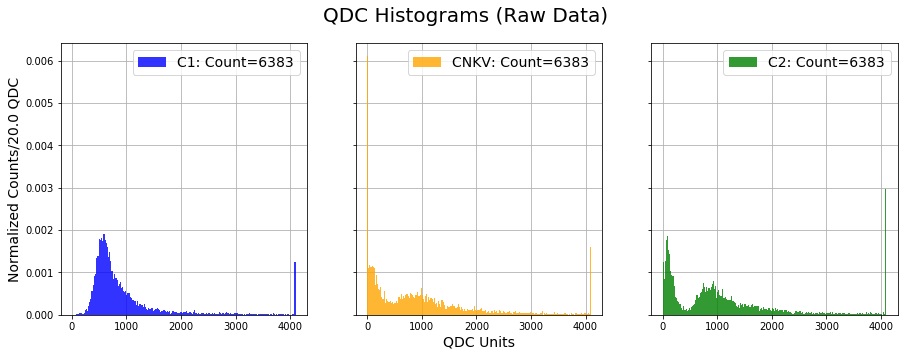

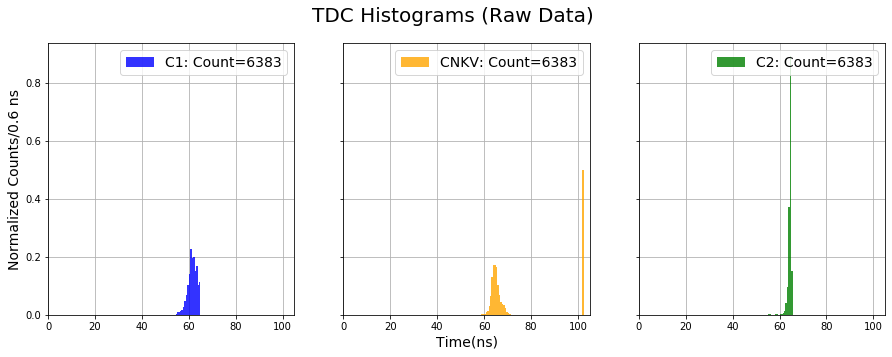

In [8]:
#RAWDATA HISTOGRAMS

################################  M  O  D  I  F  Y  ##################################################

fs = 14         #FontSize
binsizeQDC = 20
binsizeTDC = 25*TDC_to_ns
DataSet = data.copy() 
DataCounts = len(DataSet)

minTDC = 0
maxTDC = 105

#RAW_QDCHistograms

fig,(ax1,ax2, ax3) = plt.subplots(1, 3, sharex='all',sharey='all',figsize=(15,5))
binwidth = binsizeQDC   #BinSize
binst = np.arange(0,4095.0+binwidth, binwidth)

y_lab = 'Normalized Counts/'+str("{0:.1f}".format(binwidth))+' QDC'
x_lab = 'QDC Units'
#----------------------------------------------------------------
nx,bx,px = ax1.hist(DataSet['C1Q'],alpha=0.8, color='blue',
                    label ='C1: Count='+str(DataCounts),
                    bins = binst, density=True)
ax1.set_ylabel(y_lab,fontsize=fs)
ax1.set_axisbelow(True)
ax1.grid()
ax1.legend(fontsize=fs)
#----------------------------------------------------------------
nx,bx,px = ax2.hist(DataSet['C3Q'],alpha=0.8, color='orange',
                    label ='CNKV: Count='+str(DataCounts),
                    bins  =binst, density=True)
ax2.set_xlabel(x_lab,fontsize=fs)
ax2.set_axisbelow(True)
ax2.grid()
ax2.legend(fontsize=fs)
#----------------------------------------------------------------
nx,bx,px = ax3.hist(DataSet['C2Q'],alpha=0.8, color='green',
                  label ='C2: Count='+str(DataCounts),
                  bins  =binst,density=True)
ax3.set_axisbelow(True)
ax3.grid()
ax3.legend(fontsize=fs)
#----------------------------------------------------------------
fig.suptitle('QDC Histograms (Raw Data)', fontsize=20)




######################################################################################################



#RAW_TDCHistograms_(nanoseconds)

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex='all',sharey='all',figsize=(15,5))

binwidth = binsizeTDC   #BinSize
binst = np.arange(0,4095.0*TDC_to_ns+binwidth, binwidth)

y_lab = 'Normalized Counts/'+str("{0:.1f}".format(binwidth))+' ns'
x_lab = 'Time(ns)'
#----------------------------------------------------------------
nx,bx,px = ax1.hist(DataSet['C1T'],alpha=0.8, color='blue',
                    label ='C1: Count='+str(DataCounts),
                    bins = binst, density=True)
ax1.set_axisbelow(True)
ax1.set_ylabel(y_lab,fontsize=fs)
ax1.grid()
ax1.legend(fontsize=fs)
#----------------------------------------------------------------
nx,bx,px = ax2.hist(DataSet['C3T'],alpha=0.8, color='orange',
                    label ='CNKV: Count='+str(DataCounts),
                    bins  =binst, density=True)
ax2.set_xlabel(x_lab,fontsize=fs)
ax2.set_axisbelow(True)
ax2.grid()
ax2.legend(fontsize=fs)
#----------------------------------------------------------------
nx,bx,px = ax3.hist(DataSet['C2T'],alpha=0.8, color='green',
                  label ='C2: Count='+str(DataCounts),
                  bins  =binst,density=True)
ax3.set_axisbelow(True)
ax3.grid()
ax3.legend(fontsize=fs)
ax3.set_xlim(minTDC, maxTDC)
#----------------------------------------------------------------
fig.suptitle('TDC Histograms (Raw Data)', fontsize=20)

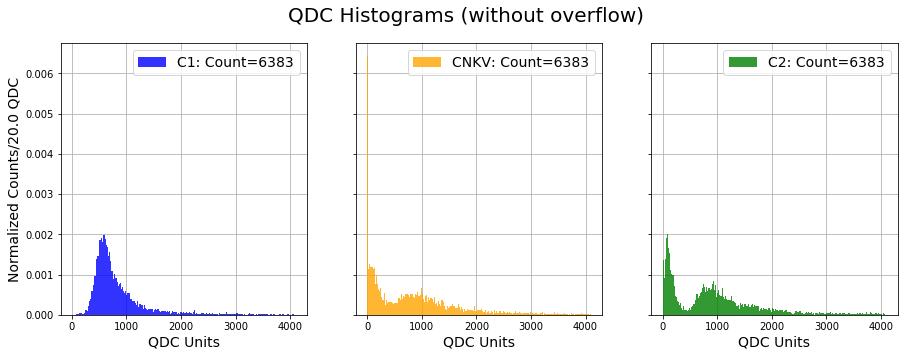

In [9]:
#inQDC HISTOGRAMS

################################  M  O  D  I  F  Y  ##################################################

fs = 14         #FontSize
binsizeQDC = 20
binsizeTDC = 25*TDC_to_ns
DataSet = Data_inQDC.copy() 

minTDC = 0
maxTDC = 105

#inQDCHistograms

######################################################################################################


fig,(ax1,ax2, ax3) = plt.subplots(1, 3, sharex='all',sharey='all',figsize=(15,5))
binwidth = binsizeQDC   #BinSize
binst = np.arange(0,4095.0+binwidth, binwidth)

y_lab = 'Normalized Counts/'+str("{0:.1f}".format(binwidth))+' QDC'
x_lab = 'QDC Units'
#----------------------------------------------------------------
nx,bx,px = ax1.hist(DataSet['C1Q'],alpha=0.8, color='blue',
                    label ='C1: Count='+str(DataCounts),
                    bins = binst, density=True)
ax1.set_xlabel(x_lab,fontsize=fs)
ax1.set_ylabel(y_lab,fontsize=fs)
ax1.set_axisbelow(True)
ax1.grid()
ax1.legend(fontsize=fs)
#----------------------------------------------------------------
nx,bx,px = ax2.hist(DataSet['C3Q'],alpha=0.8, color='orange',
                    label ='CNKV: Count='+str(DataCounts),
                    bins  =binst, density=True)
ax2.set_xlabel(x_lab,fontsize=fs)
ax2.set_axisbelow(True)
ax2.grid()
ax2.legend(fontsize=fs)
#----------------------------------------------------------------
nx,bx,px = ax3.hist(DataSet['C2Q'],alpha=0.8, color='green',
                  label ='C2: Count='+str(DataCounts),
                  bins  =binst,density=True)
ax3.set_xlabel(x_lab,fontsize=fs)
ax3.set_axisbelow(True)
ax3.grid()
ax3.legend(fontsize=fs)

#----------------------------------------------------------------
fig.suptitle('QDC Histograms (without overflow)', fontsize=20)
plt.savefig(PlotFolder+'/inQDC_Histograms.pdf')

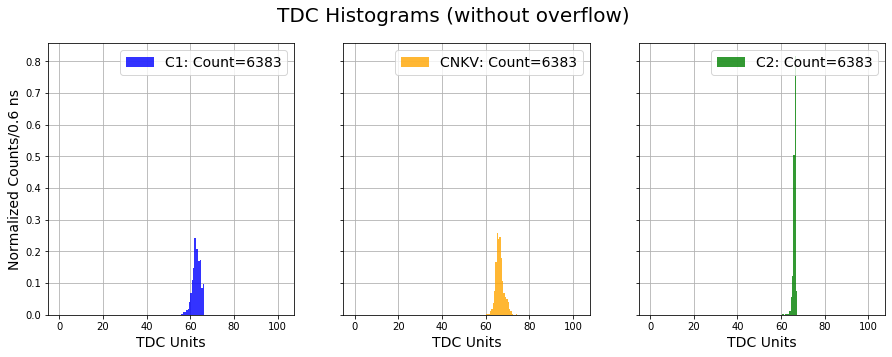

In [10]:
#inTDC HISTOGRAMS

################################  M  O  D  I  F  Y  ##################################################

fs = 14         #FontSize
binsizeQDC = 20
binsizeTDC = 25*TDC_to_ns
DataSet = Data_inTDC.copy() 

#inQDCHistograms

######################################################################################################


fig,(ax1,ax2, ax3) = plt.subplots(1, 3, sharex='all',sharey='all',figsize=(15,5))
binwidth = binsizeTDC   #BinSize
binst = np.arange(0,4095.0*TDC_to_ns+binwidth, binwidth)

y_lab = 'Normalized Counts/'+str("{0:.1f}".format(binwidth))+' ns'
x_lab = 'TDC Units'
#----------------------------------------------------------------
nx,bx,px = ax1.hist(DataSet['C1T'],alpha=0.8, color='blue',
                    label ='C1: Count='+str(DataCounts),
                    bins = binst, density=True)
ax1.set_xlabel(x_lab,fontsize=fs)
ax1.set_ylabel(y_lab,fontsize=fs)
ax1.set_axisbelow(True)
ax1.grid()
ax1.legend(fontsize=fs)
#----------------------------------------------------------------
nx,bx,px = ax2.hist(DataSet['C3T'],alpha=0.8, color='orange',
                    label ='CNKV: Count='+str(DataCounts),
                    bins  =binst, density=True)
ax2.set_xlabel(x_lab,fontsize=fs)
ax2.set_axisbelow(True)
ax2.grid()
ax2.legend(fontsize=fs)
#----------------------------------------------------------------
nx,bx,px = ax3.hist(DataSet['C2T'],alpha=0.8, color='green',
                  label ='C2: Count='+str(DataCounts),
                  bins  =binst,density=True)
ax3.set_xlabel(x_lab,fontsize=fs)
ax3.set_axisbelow(True)
ax3.grid()
ax3.legend(fontsize=fs)

#----------------------------------------------------------------
fig.suptitle('TDC Histograms (without overflow)', fontsize=20)
plt.savefig(PlotFolder+'/inTDC_Histograms.pdf')

In [12]:
C1_C2_Counts = len(Data)
C1_CNKV_C2_Counts = len(Data_inTDC)

N = C1_CNKV_C2_Counts
M = C1_C2_Counts

Eff_CNKV = N/M
Sigma_Eff_CNKV= Eff_CNKV*np.sqrt((1.0-Eff_CNKV)/N)

print('Cherenkov Detector Efficiency')
print("{0:.3f}".format(100*Eff_CNKV)+' ± '+"{0:.3f}".format(Sigma_Eff_CNKV)+'%')

Cherenkov Detector Efficiency
68.729 ± 0.006%
